# Exploratory Data Analysis + Statistical Machine Translation

## Jake Watts

For the first section of the report I preform exploratory data analysis on a data set containing paris of english and frnch sentences from the Tatoeba Project and downloaded from http://www.manythings.org/anki/. The dataset is limited to sentences that have been proofread and translated by native speakers however it is still possible that translation errors are present.

After exploring the data, I build a Statistical Translation Machine using a bigram language model and IBM's model 1 as the translation model. I then evaluate the data by calculating BLEU scores. This model will be used as a baseline to compare to Neural Machine Translations as we wanted to start with simplest models to progress into more modern translation techniques.

Sources:

https://github.com/Santi-P/Alignment-Model-

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

http://mt-class.org/jhu/slides/lecture-ibm-model1.pdf

https://github.com/PacktPublishing/Hands-On-Natural-Language-Processing-with-Python/blob/master/Chapter10/01_example.ipynb

https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

In [1]:
import re
import numpy
import pickle
import gzip
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import nltk
from nltk.translate.ibm1 import IBMModel1
from nltk.translate.api import AlignedSent
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sys import getsizeof

## Exploratory Data Analysis

In this portion of the report I process and explore the data.

Loading dataset

In [2]:
!! curl -O http://www.manythings.org/anki/fra-eng.zip
!! unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

Cleaning text file to remove unwanted text

In [8]:
data_path = "fra.txt"
e_f = open('e_f.txt', 'w')

with open('fra.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[:len(lines) - 1]:
    input_text, target_text, _ = line.split("\t")
    output = target_text + "\t" + input_text + '\n'
    e_f.write(output)

Shuffling observations and splitting text into train and test. The training data consists of 153,873 sentences or approximately 80% of the data.

In [9]:
lines = open('e_f.txt').readlines()
random.seed(10)
random.shuffle(lines)
split = int(round(len(lines)* .8, 0))
print(split)

open('e_f.txt', 'w').writelines(lines)
open('train.txt', 'w').writelines(lines[:split])
open('test.txt', 'w').writelines(lines[split:])

153873


Transforming data from text to vector format.

In [5]:
input_texts = []
target_texts = []

with open('e_f.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[:len(lines) - 1]:
    target_text, input_text = line.split("\t")
    input_texts.append(input_text)
    target_texts.append(target_text)

In [6]:
train_eng, train_fre = input_texts[:split], target_texts[:split]
test_eng, test_fre = input_texts[split:], target_texts[split:]

The input language for the model will be English and the target language will be French.

In [ ]:
print("Input text:", train_eng[0], "\nTarget Text:", train_fre[0])

Input text: Do you understand me? 
Target Text: Vous me comprenez ?


Splitting the sentences into lists.

In [7]:
def read_sents(vec):
    sents = []
    for v in vec:
      sents.append(v.split())
    return sents

train_eng_split, train_fre_split = read_sents(train_eng), read_sents(train_fre)
test_eng_split, test_fre_split = read_sents(test_eng), read_sents(test_fre)

In [ ]:
flat_list = []
for sublist in train_eng_split:
    for item in sublist:
        flat_list.append(item)

In [ ]:
df = pd.DataFrame(list(zip(train_eng, train_fre)),
               columns =['English', 'French'])

Looking at the characters per sentence we can see that the english and french sentences share a similar distribution that is right-skewed. Most sentences are between 0 and 50 words while a small amount are around 300 in both english and french.

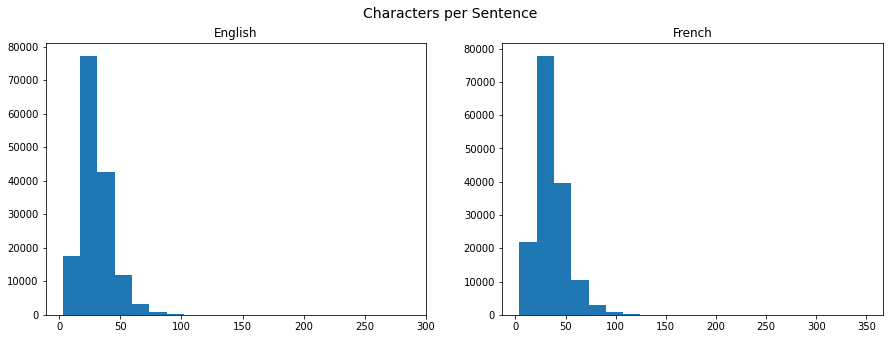

In [ ]:
x = df['English'].str.len() 
y = df['French'].str.len() 

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1) 
plt.hist(x, bins=20)
plt.title('English')

figure.add_subplot(1, 2, 2)
plt.hist(y, bins=20)
plt.title('French')

figure.suptitle('Characters per Sentence', fontsize=14)

plt.show()

From the graph of words per sentence the distributions are similar, however french sentences tend to have slightly more words per sentence than english words. This could effect translation as it could mean that some pairs of words in french could translate to a single word in english.

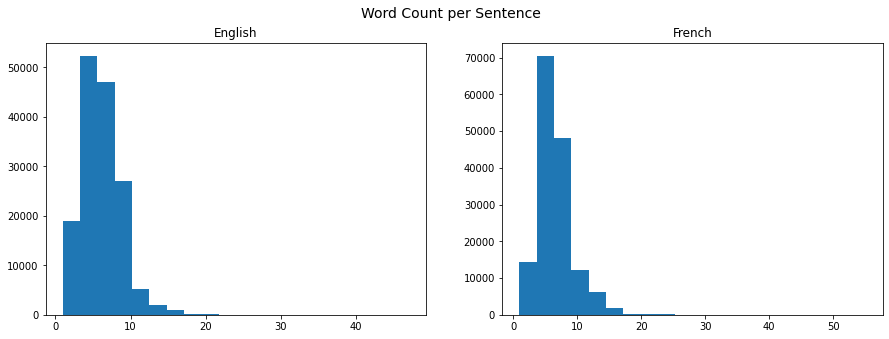

In [ ]:
x = df['English'].str.split().\
    map(lambda x: len(x))
y = df['French'].str.split().\
    map(lambda x: len(x))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1) 
plt.hist(x, bins=20)
plt.title('English')

figure.add_subplot(1, 2, 2)
plt.hist(y, bins=20)
plt.title('French')

figure.suptitle('Word Count per Sentence', fontsize=14)

plt.show()

The average word size per sentence between english and french are very similar as well. The graph also appears to be right-skewed. Most sentenctes have an average word size of 4-5 characters.

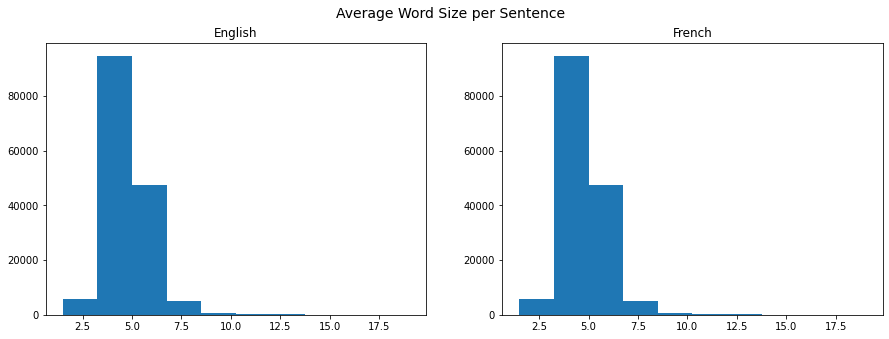

In [ ]:
x = df['English'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x))

y = x = df['French'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1) 
plt.hist(x)
plt.title('English')

figure.add_subplot(1, 2, 2)
plt.hist(y)
plt.title('French')

figure.suptitle('Average Word Size per Sentence', fontsize=14)

plt.show()

Next we can look at the most common stop words. First I will get a list of english and french stop words from nltk.

In [ ]:
nltk.download('stopwords')
stop_en = set(stopwords.words('english'))
stop_fr = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Counting the most common stop words in each language.

In [ ]:
corpus_en, corpus_fr = [], []
corpus_en, corpus_fr = [word for i in train_eng_split for word in i], [word for i in train_fre_split for word in i],

from collections import defaultdict
dic = defaultdict(int)
for word in corpus_en:
    if word in stop_en:
        dic[word]+=1

dic2 = defaultdict(int)
for word in corpus_fr:
    if word in stop_fr:
        dic2[word]+=1

Looking at the most common stop words in english we can see that the top three are "to', "you" and "the". The tope three in french are "de", "pas" and "que". I do not know french but looking up these words shows that they are defined as "of", "not" and "that". It is interesting that the most common stop words used do not necassarily correspond and I imagine that this will add some diffuclty for translation.

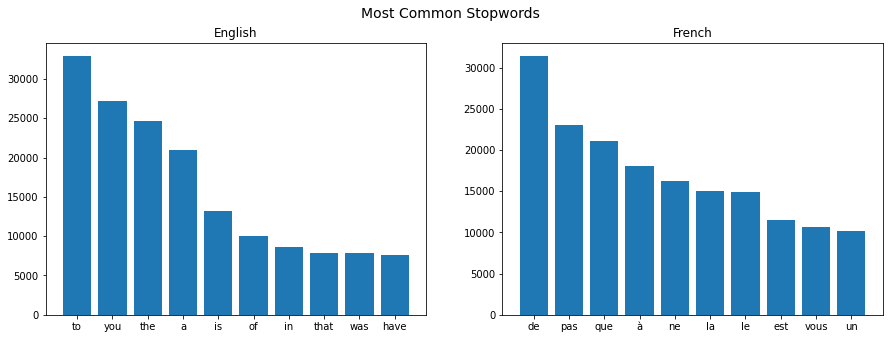

In [ ]:
figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1) 
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x, y)
plt.title('English')


figure.add_subplot(1, 2, 2)
top = sorted(dic2.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x, y)
plt.title('French')

figure.suptitle('Most Common Stopwords', fontsize=14)
plt.show()

Looking at the most common words used in English other than stop words we can see that the most popular words is a name "Tom" which would be the same in english and french. And it is also the most popular word in french. Other words included are contractions that I might consider stop words. "Think", "want" and "know" seem to be the common words that are not contractions or stop words.

[Text(0.5, 1.0, 'Most Common Words')]

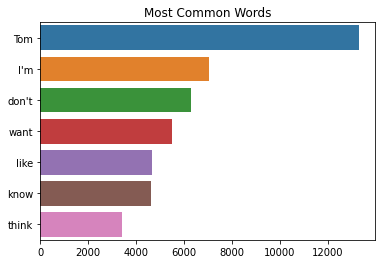

In [ ]:
counter = Counter(corpus_en)
most=counter.most_common()

x, y= [], []
for word, count in most[:40]:
    if (re.sub(r'[^\w\s]', '', word.lower()) not in stop_en):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x).set(title='Most Common Words')

Finally I wanted to explore  bigrams as they are used in the language modeling portion of the statistical machine translation model. Here I define a function to find the top bigrams. Which is a list of two words that appear next to eachother in a sentence.

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

The most popular bigrams in english do not necassarily correspond to the most popular in french. For example, "je ne is the most popular in french but it translates to "I do not" which would be three words in english. "Je suis" is also popular in french which translates to "I am" which would be a bigram in english, however it is not one of the most popular english bigrams. This demonstrates that some phrases may just be used with different frequency in other languages even when conveying the same meaning.

[Text(0.5, 1.0, 'Most Common English Bigrams')]

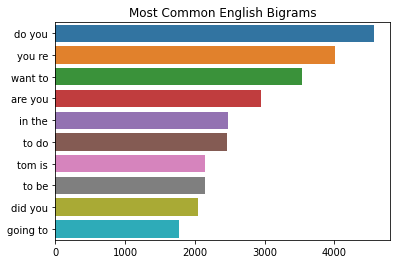

In [ ]:
top_n_bigrams = get_top_ngram(df["English"] ,2)[:10] 
x, y = map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x).set(title='Most Common English Bigrams')

[Text(0.5, 1.0, 'Most Common French Bigrams')]

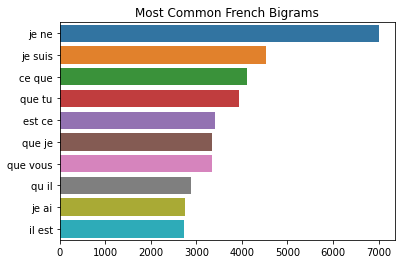

In [ ]:
top_n_bigrams = get_top_ngram(df["French"] ,2)[:10] 
x, y = map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x).set(title='Most Common French Bigrams')

## Statistical Machine Translation (English ⇒ French)

In this portion of the notebook I implement the noisy channel model for statistical machine translation. The noisy channel model includes both a language model and a probability model. The language model assigns probabilities to words in the target language and is constructed, in this case, from a bigram language model trained from large corpus in the target language. The translation model assigns a probability of the input language given the target language. The model for the report uses an implementation of IBM's model 1. The final output of the model is given by finding the sentence that maximizes the product of the probability given by the language model and the translation model.

Below is the function for the N-gram model. Which is used to calculate the probability of words occuring in the target language.

In [13]:
class Ngrams:
	""" Naive Interpolated Bigram Language Model
		contains minimal features and smoothed by interpolating
		with unigrams and small unknown word number. Can take 
		unformatted text files. e.g the brown corpus provided. 
    """
	def __init__(self,fname):
		self.lang_mod, self.uni = self.ngrams(fname)


	def ngrams(self, fname):
		""" main language model builder"""
		text = []
		with open(fname,"r") as f:
			for line in f:
				text.extend(line.split())
		uni = Counter(text)
		bigram = zip(text, text[1:])
		lm = Counter(bigram)
		#lm = Counter(bigram)
		#print(lm["there","is"])
		print("normalizing language model")

		sum_uni = sum(uni.values())
		for key,val in lm.items():
			w1,w2 = key
			lm[w1,w2] = val/uni[w1]
		for w in uni.keys():
			uni[w] /= sum_uni


		return lm, uni



	def get_prob(self,w1, w2, unigram_weight = 0.1):
		""" get interpolated probability """
		# prev word not found
		unknown_weight = 0.00000000000000001

		bigram_weight = 1 - unigram_weight - unknown_weight
		bigram_prob = 0.0
		unigram_prob = 0.0
		if self.lang_mod.get((w1,w2)) != None:
			bigram_prob = self.lang_mod[w1,w2]
			
		if self.uni.get(w2) != None:
			unigram_prob = self.uni[w2]
		
		
		return bigram_weight * bigram_prob + unigram_weight * unigram_prob  + unknown_weight

Below are a collection of functions used to create the language model, which is an implementation of IBM model 1. I altered the original code from github to translate from english to french rather than french to english. For the bigram language model I used a french corpus taken from Project Gutenburg (https://www.gutenberg.org/files/16887/16887-0.txt).

In [11]:
class AlignmentModel:
	""" Implementation of IBM Model 1. Uses EM to learn lexical/alighment
	 probabilities. Language model is included to turn this into a noisy-channel
	 model. A simple decode algorithm is used. External scripts for evaluation
	 Per convention, variables with e mark target language and f for source, or
	 noisy model """
	def __init__(self):

		# Vocabulary indices
		self.__e_vocab = dict()
		self.__f_vocab = dict()
		# inverse mapping of the above
		self.ind2word_f = dict()
		self.ind2word_e = dict()

		# main lexical alignment weights 
		self.trans_prob =[]

		# sentinels for keeping 
		self.__num_e = int()
		self.__num_f = int()

		# 
		self.data_type = numpy.float16
		self.lang_mod = []

		self.punct_filter =re.compile(r'[^\w]')

	def build_save_lm(self,fname):
		""" builds N-gram language model and dumps to binary """
		with open(fname,"wb") as langfile:
			self.lang_mod =  Ngrams("fr.txt")
			pickle.dump(self.lang_mod, langfile)
		
	def load_lm(self,fname):
		""" loads N-gram language model from binary file"""
		print("loading language model")
		with open(fname,"rb") as langfile:
			self.lang_mod = pickle.load(langfile) 

	def translate_sentence(self, in_sent):
		""" translates sentence by simply replacing words """
		in_sent = in_sent.split()
		return " ".join([self.translate_word(w) for w in in_sent])



	def decode(self, in_sent):
		""" A naive noisy channel decoder
			fetches a few candidate translations for a target word
			selects the word which has the
			 highest probability given previous word. 
			 This can be highly improved upon by using a variation of the viterbi algorithm
			 e.g viterbi with beamsearch.
			 takes sentence string as argument and returns translated sentence as string 
			  """
		#print("translating :", in_sent)
		in_sent = (self.punct_filter.sub(' ',in_sent)).lower()
		in_sent = in_sent.split()
		if len(in_sent) < 2:
			if len(in_sent) > 0:
				return self.translate_word(in_sent[0])
			else:
				return ""
		results = [self.translate_word(in_sent[0])]
		# go through words in sentence
		for i in range(1,len(in_sent)):
			prev_word = results[i-1]
			curr_word = in_sent[i]
			# get 10 candidate translations
			# this number can be varied

			candidates, scores = self.get_n_best(curr_word,5)
			# candidate with highest probability
			tmp_cand = [self.lang_mod.get_prob(prev_word,w)*score for w,score in zip(candidates,scores)]
			enum = list(enumerate(tmp_cand))

			best = max(enum, key = lambda x: x[1])[0]

			results.append(candidates[best])

		return " ".join(results)

	def lazy_reader(self, fname):
		""" A corpus iterator. Takes a tsv file
			in the form 
			FRENCH SENTENCE 1 <TAB>  ENGLISH SENTENCE 1
			FRENCH SENTENCE 2 <TAB>  ENGLISH SENTENCE 2
			performs minimal tokenization and sets all the words to lowercase
			"""
		# native e to f translation
		with open(fname,"r") as f:
			pattern = re.compile(r'[^\w]')
			for line in f:
				# verify input later
				foreign , native= line.split("\t")

				native = (pattern.sub(' ',native)).lower()
				foreign = (pattern.sub(' ',foreign)).lower() 
				yield  native.strip().split(), foreign.strip().split()


	def trans_prob_getter(self, e_word, f_word):
		""" getter for translation probability"""
		ind_e = self.__e_vocab[e_word]
		ind_f = self.__f_vocab[f_word]
		return self.trans_prob[ind_e][ind_f], ind_e, ind_f
	
	# f to e  

	def get_max(self,word):
		""" get the best translation of word"""
		try:
			ind = self.__e_vocab[word]
		except KeyError:
			print("word not found")
			return 0
		res = numpy.argmax(self.trans_prob[ind])
		return res
	
	def get_n_best(self,word, n = 10):
		""" get k best for a given target word"""
		# argpartition used to avoid sorting the whole array
		# this approach is O(n) worst case
		try: 
			ind = self.__e_vocab[word]
		except KeyError:
			ind = 0
			#raise(ValueError("unknown vocabulary"))
		res = numpy.argpartition(self.trans_prob[ind],-n)
		scores = [self.trans_prob[ind][s] for s in res[-n:]]
		return [self.ind2word_f[word] for word in res[-n:]], scores

	def translate_word(self,word):
		ind_of_best = self.get_max(word)
		return self.ind2word_f[ind_of_best]

	# e to f

	### wrapper functions but for the other way around

	def get_max_e(self,word):
		ind = self.__f_vocab[word]
		res = numpy.argmax(self.trans_prob.T[ind])
		return res
	
	def get_n_best_e(self,word, n = 10):
		# argpartition used to avoid sorting the whole array
		# this approach is O(n) worst case

		ind = self.__f_vocab[word]
		res = numpy.argpartition(self.trans_prob.T[ind],-n)
		return [self.ind2word_f[word] for word in res[-n:]]



	def translate_word_e(self,word):
		ind_of_best = self.get_max_e(word)
		return self.ind2word_e[ind_of_best]


	
	def save_weights(self, tm_fname, idx_fname):
		""" dumps translation probabilities and 
		indices into two files"""
		with open(tm_fname, "wb") as w_file:
			numpy.save(w_file, self.trans_prob)
		with open(idx_fname, "wb") as idx_file:
			pickle.dump((self.ind2word_e, self.ind2word_f, self.__e_vocab, self.__f_vocab),idx_file)

	def load_weights(self, tm_fname, idx_fname):
		""" loads translation probabilities and 
			indices from two files"""

		with open(tm_fname, "rb") as w_file:
			self.trans_prob = numpy.load(w_file)

		with open(idx_fname, "rb") as idx_file:
			self.ind2word_e, self.ind2word_f, self.__e_vocab, self.__f_vocab = pickle.load(idx_file)

	def train(self, fname, iterations = 3, debug = False):
		""" IBM Model 1 alignment model. Trains lexical alignments using
		expectation maxization. Faithful implementation of the pseudo-code as seen 
		in the slides from P. Koehn
		
		This algorithm converges very quickly (2-3 iterations). This can use up a lot of memory. To 
		solve this I recommend using half-precision floats (np.float16). This takes 1/4 less memory compared
		to numpy default doubles. There is a trade off in terms of speed but it is relative negligeble. 
		The debug option prints the sum of the element-wise difference between previous iterations.
		The smaller the better. 
		
		"""
		# train t(f|e ) or corpus
		# collect counts and build array
		count_e_words = 0
		count_f_words = 0

		for e_sent, f_sent in self.lazy_reader(fname):
			for e_token in e_sent:
				if self.__e_vocab.get(e_token) == None:
					self.__e_vocab[e_token] = count_e_words
					self.ind2word_e[count_e_words] = e_token
					count_e_words += 1

			for f_token in f_sent:
				if self.__f_vocab.get(f_token) == None:
					self.__f_vocab[f_token] = count_f_words
					self.ind2word_f[count_f_words] = f_token
					count_f_words += 1

		uniform = 1 / (count_e_words + count_f_words -2 )
		dimensions = (count_e_words, count_f_words)

		print(count_e_words)
		print(count_f_words)
		self.trans_prob = numpy.full(dimensions, uniform, dtype=self.data_type)
		

		for it in range(iterations):
			print("starting iteration: ", it)
			count_ef = numpy.zeros(dimensions, dtype=self.data_type)
			total_f = numpy.zeros((dimensions[1],), dtype=self.data_type)

			for e_sent, f_sent in self.lazy_reader(fname):                
				sent_total = {e : 0 for e in set(e_sent)}
				for e_token in e_sent:
					for f_token in f_sent:
						sent_total[e_token] += self.trans_prob_getter(e_token,f_token)[0]

				for e_token in e_sent:
					for f_token in f_sent:
						#ind_e = self.__e_vocab[e_token]
						#ind_f = self.__f_vocab[f_token]

						tp, ind_e, ind_f =  self.trans_prob_getter(e_token,f_token)
						val = tp / sent_total[e_token]
						count_ef[ind_e][ind_f] += val
						total_f[ind_f] += val 

			print("normalizing")
			if debug:
				print("convergence")
				print(numpy.abs(numpy.sum(self.trans_prob - count_ef / total_f ,dtype = self.data_type)))
			self.trans_prob = count_ef / total_f

			
	def translate_all(self,fname, print_out = False):
		""" translates all sentences in a given file"""
		results = []
		with open(fname,"r") as f:
			for line in f:
				translation = self.decode(line)
				if print_out:
					print(translation)
				results.append(translation)
		return results

	def verify(self):
		""" debugging function for checking translation probabilities
			by summing up the rows and checking if equal to 1
			using half-precision floats often causes
			a lot of rows to not add up to 1 correctly.
			In practice this doesn't make that big of a difference"""
		width, length = self.trans_prob.shape
		print(width,length)
		
		for i in numpy.sum(self.trans_prob,dtype=self.data_type,axis=0):
			#if not numpy.isclose(i,1.0,rtol=1e-2):
			print(i)

Training model

In [14]:
model_1 = AlignmentModel()
model_1.build_save_lm("langmod_fr")
model_1.train("train.txt",iterations = 3)

normalizing language model
14322
23745
starting iteration:  0
normalizing
starting iteration:  1
normalizing
starting iteration:  2
normalizing


## BLEU Scores

The BLEU (BiLingual Evaluation Understudy) score is a method for evaluating the quality of a machine translation text. Classifying the quality of a translation is not an objective measure since there are multiple valid ways to translate most sentences. BLEU scores serve as a way to interpret translation performance by comparing the actual translation or mutliple valid translations to the machine translation and assigning a score from 0 to 1 to rate the translation, 1 being the best. 1-gram scores compare the words in the translation while bigrams compare pairs of words while n-gram compares groups of n-words. In this report we weight n-grams 1-4 equally to calculate our score.

Looking at translation it appears that the model is able to correctly translate some words in the sentence but often the meaning is not fully conveyed. For example the first example sentence is "we want a complete evaluation". However the french translation is "nous veux de compléter actifs" which roughly means "
we want to complete assets" which contains some of the right words but does share the same meaning. Overall most BLEU scores are equal to 0 while there are a few better translations equal to 0.19. WThe BLEU scores would be more accurate if I had more reference translations to use, since sentences can often be translated in more than one valid ways. However, the overall low scores indicate that there is a lot of room for improvement with this model.

In [17]:
smoothie = SmoothingFunction().method4

for i in range(20):
  translation = model_1.decode(test_eng[i])
  score = sentence_bleu(test_fre_split[i], translation.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
  print('TEXT: ', test_eng[i], '\nACTUAL:', test_fre[i], '\nPREDICTED:', translation)
  print('BLEU SCORE:', str(score), "\n")

TEXT:  We want a complete evaluation. 
ACTUAL: Nous voulons une évaluation complète. 
PREDICTED: nous veux de compléter actifs
BLEU SCORE: 0 

TEXT:  Your answer was wrong. 
ACTUAL: Ta réponse était fausse. 
PREDICTED: votre réponse était tort
BLEU SCORE: 0 

TEXT:  I don't see how I can help you. 
ACTUAL: Je ne vois pas comment je peux vous aider. 
PREDICTED: j pas de voir comment que peuvent aider vous
BLEU SCORE: 0.1969244213551724 

TEXT:  Tom is passionate. 
ACTUAL: Tom est passionné. 
PREDICTED: tom est passionne
BLEU SCORE: 0 

TEXT:  Women age faster than men. 
ACTUAL: Les femmes vieillissent plus vite que les hommes. 
PREDICTED: femmes âge vite que hommes
BLEU SCORE: 0 

TEXT:  What would your father think? 
ACTUAL: Que penserait ton père ? 
PREDICTED: quelles ferait votre père pense
BLEU SCORE: 0 

TEXT:  What is a think tank? 
ACTUAL: Qu'est un cercle de réflexion ? 
PREDICTED: quelles est un pense réservoir
BLEU SCORE: 0 

TEXT:  I don't think I'll ever get used to this. 
A

# Summary

Overall this statistical machine translation model was a good place to start with machine translation as the method of translation is rather simple to understand and implement. The model performance overall definitely needs improvement. While sometimes the general idea of the sentence carries through in the translation, the majority of translation have awkward syntax and appear more as a jumble of words with a few key translated phrases rather than a coherent sentence.

This model also serves as a baseline for the models in the next portions of the report which perform better and use more sophisticated techniques such as a Naive RNN and Encoder-Decoder with GRU trained on the same French-English data. I anticipate that these models will easily outperform the noisy-channel model.
